# Long Short 14hxx base on High Low of 9h - Strategy - Backtesting 

### Import Library

In [16]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [17]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [18]:
data = dataset.copy()

In [34]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2024-11-01 00:00:00']

In [35]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2024-11-01 09:00:00,1340.4,1340.4,1337.5,1337.8,10641
2024-11-01 09:05:00,1337.8,1338.6,1337.2,1338.1,5701
2024-11-01 09:10:00,1338.0,1338.0,1336.9,1337.5,3227
2024-11-01 09:15:00,1337.5,1338.0,1337.1,1337.7,2665
2024-11-01 09:20:00,1337.7,1338.8,1337.4,1338.6,3173
...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1343.0,1340.3,1341.3,7141
2025-02-14 14:20:00,1340.9,1341.9,1340.5,1341.4,4593
2025-02-14 14:25:00,1341.1,1342.5,1340.7,1342.5,4207


In [37]:
def get_data_high_9h(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute >= 900]
    tick = tick[100 * tick.index.hour + tick.index.minute < 1000]
    if not tick.empty:
        return tick.max()

def get_data_low_9h(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute >= 900]
    tick = tick[100 * tick.index.hour + tick.index.minute < 1000]
    if not tick.empty:
        return tick.min()
    
daily_data = data.copy().resample('D').agg({
        'High': get_data_high_9h,
        'Low': get_data_low_9h,
        'Close': 'last'
    }).rename(columns={'High': 'High_9h', 'Low': 'Low_9h', 'Close': 'day_Close'})
daily_data.dropna(subset=['day_Close'], inplace=True)

In [62]:
def cal_signal(r):
    signal = ''
    if r.name.hour != 14:
        return ''
    if r['Open'] < r['High_9h'] < r['Close']:
        signal = 'long'
    elif r['Open'] > r['Low_9h'] > r['Close']:
        signal = 'short'
    return signal

def prepare_data(htd, day_htd):
    htd = htd.assign(time_d=pd.PeriodIndex(htd.index, freq='1D').to_timestamp())
    df = pd.merge(htd, day_htd, left_on="time_d", right_index=True, how="left")
    df['signal'] = df.apply(lambda r: cal_signal(r), axis=1)
    return df

In [63]:
prepared_data = prepare_data(data, daily_data)
prepared_data.dropna(inplace=True)

In [64]:
prepared_data[prepared_data.signal != '']

,Open,High,Low,Close,Volume,time_d,High_9h,Low_9h,day_Close,signal
Date,,,,,,,,,,
2024-11-07 14:15:00,1338.3,1338.6,1335.3,1335.4,8413,2024-11-07,1343.6,1335.7,1334.7,short
2024-11-13 14:25:00,1309.6,1313.1,1309.5,1313.0,10061,2024-11-13,1310.7,1303.8,1307.3,long
2024-11-18 14:15:00,1274.6,1279.4,1274.6,1277.7,16011,2024-11-18,1275.6,1267.5,1273.2,long
2024-11-19 14:25:00,1265.0,1265.0,1262.7,1263.2,14191,2024-11-19,1274.8,1264.5,1262.3,short
2024-11-22 14:00:00,1294.7,1294.7,1291.3,1292.3,11661,2024-11-22,1299.0,1292.7,1298.0,short
2024-11-27 14:00:00,1308.3,1309.0,1307.9,1308.6,6948,2024-11-27,1308.4,1304.2,1307.8,long
2024-11-28 14:00:00,1310.2,1310.2,1308.2,1308.3,5128,2024-11-28,1318.7,1309.6,1305.5,short
2024-12-03 14:20:00,1315.4,1316.0,1314.5,1316.0,3638,2024-12-03,1315.9,1309.7,1314.0,long
2024-12-04 14:00:00,1308.8,1309.9,1305.5,1305.8,7726,2024-12-04,1312.8,1306.0,1303.0,short


In [75]:
class MainStrategy(Strategy):
    reward_on_risk = 3
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        if self.position:
            return 
        signal = self.data.signal[-1]
        close_price = self.data.Close[-1]
        low_price = self.data.Low[-1]
        high_price = self.data.High[-1]
        if signal == 'long':
            sl = min(low_price, close_price - 1.5) - 0.1
            tp = close_price + self.reward_on_risk * (close_price - sl)
            self.buy(size=1, sl=sl, tp=tp)
        elif signal == 'short':
            sl = max(high_price, close_price + 1.5) + 0.1
            tp = close_price - self.reward_on_risk * (sl - close_price)
            self.sell(size=1, sl=sl, tp=tp)

In [76]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [77]:
stats

Start                     2024-11-01 09:00:00
End                       2025-02-14 14:45:00
Duration                    105 days 05:45:00
Exposure Time [%]                    2.190396
Equity Final [$]                   1477.07898
Equity Peak [$]                    1501.51613
Return [%]                          -1.528068
Buy & Hold Return [%]                0.298998
Return (Ann.) [%]                   -5.392656
Volatility (Ann.) [%]                1.071931
Sharpe Ratio                        -5.030786
Sortino Ratio                       -5.034064
Calmar Ratio                        -2.867556
Max. Drawdown [%]                   -1.880576
Avg. Drawdown [%]                   -0.943638
Max. Drawdown Duration       88 days 00:25:00
Avg. Drawdown Duration       44 days 00:18:00
# Trades                                   23
Win Rate [%]                        34.782609
Best Trade [%]                       0.269258
Worst Trade [%]                     -0.295973
Avg. Trade [%]                    

In [78]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,251,253,1334.59950,1333.9,0.69950,0.000524,2024-11-07 14:20:00,2024-11-07 14:30:00,None,0 days 00:10:00
1,1,608,609,1278.28337,1274.5,-3.78337,-0.002960,2024-11-18 14:20:00,2024-11-18 14:25:00,None,0 days 00:05:00
2,-1,809,809,1292.11225,1294.8,-2.68775,-0.002080,2024-11-22 14:05:00,2024-11-22 14:05:00,None,0 days 00:00:00
3,1,962,964,1308.69249,1307.0,-1.69249,-0.001293,2024-11-27 14:05:00,2024-11-27 14:15:00,None,0 days 00:10:00
4,-1,1013,1018,1307.90751,1307.7,0.20751,0.000159,2024-11-28 14:05:00,2024-11-28 14:30:00,None,0 days 00:25:00
5,1,1170,1170,1316.29477,1314.4,-1.89477,-0.001439,2024-12-03 14:25:00,2024-12-03 14:25:00,None,0 days 00:00:00
6,-1,1217,1222,1305.40826,1304.5,0.90826,0.000696,2024-12-04 14:05:00,2024-12-04 14:30:00,None,0 days 00:25:00
7,-1,1472,1477,1338.19842,1339.1,-0.90158,-0.000674,2024-12-11 14:05:00,2024-12-11 14:30:00,None,0 days 00:25:00
8,-1,1525,1528,1337.99848,1340.2,-2.20152,-0.001645,2024-12-12 14:15:00,2024-12-12 14:30:00,None,0 days 00:15:00
9,-1,1679,1681,1327.40166,1329.3,-1.89834,-0.001430,2024-12-17 14:20:00,2024-12-17 14:30:00,None,0 days 00:10:00


In [79]:
# bt.plot()

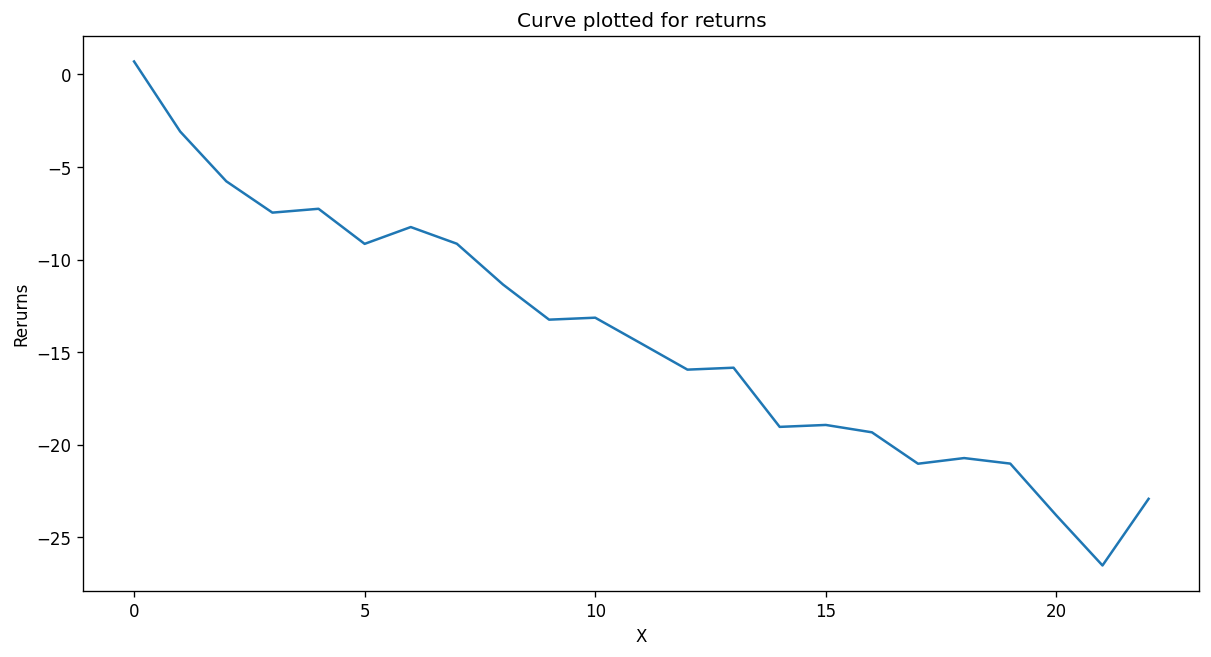

In [80]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()